In [1]:
import mrc as Mrc
from scipy.fftpack import fftn, fftshift
import numpy as np
from tnia.plotting.projections import show_xyz_slice
import numpy as np
from tnia.plotting.projections import show_xyz_slice_center
import os
import sys

print(os.getcwd())

sys.path.insert(1, r'../../python')

from simreconpython.separate import makematrix, get_volume, separate, apodize_3d, normalize


c:\Users\bnort\work\Janelia\code\simrecon\notebooks\sandbox


In [13]:
raw_name = r'D:\Janelia\Data 2024-06-12\rois_1\roi_128.mrc'
raw_name = r'D:\Janelia\Data 2024-06-06\Wiener, gammaApo and SupressR parameter testing\488nm comparison Brian\CELL 4 - 1.0W 300ms updated HWPQWP pos_20240503_115909\488 nm 5 phases 0.81 NA React_All Linear SIM_cam1_1.mrc'
raw_name = r'D:\Janelia\Data 2024-06-30\488cm cell 5 good signal_20240627_131236  Fail\488 nm 5 phases 0.81 NA React_All Linear SIM_cam1_1.mrc'
raw_mrc = Mrc.Mrc(raw_name)
raw = raw_mrc.data#[:,470:470+64,750:750+64]
print(raw.shape)
num_phases =      5
num_directions = 3

sxy, sxy, sz = raw_mrc.header.d[0], raw_mrc.header.d[1], raw_mrc.header.d[2]
print(sxy, sxy, sz)

(240, 1024, 1024)
0.13 0.13 0.25


In [14]:
raw = apodize_3d(raw, 10)
raw = normalize(raw)

0
1
2
3
4


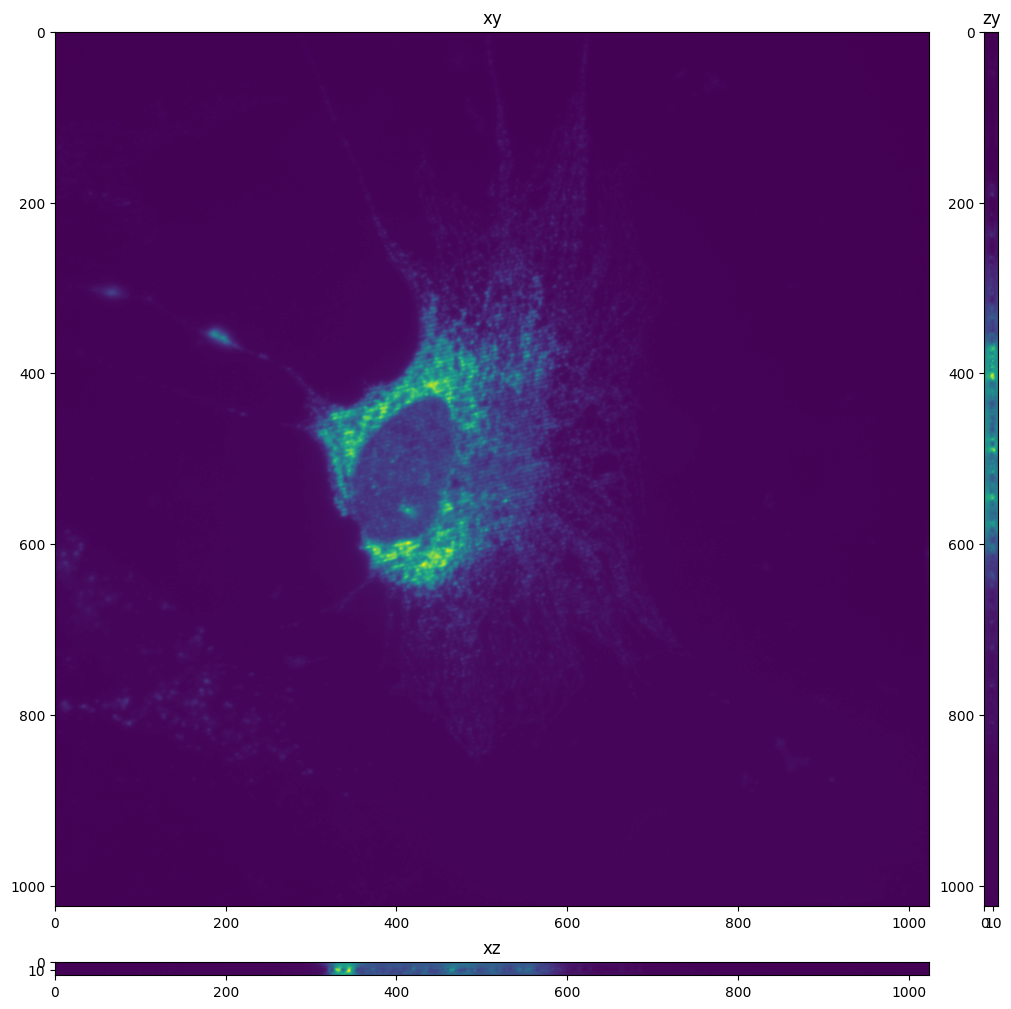

In [15]:
dir = 0
data_list = []
for n in range(num_phases):
    temp = get_volume(raw, n, dir, num_phases, num_directions)
    data_list.append(temp)

fig = show_xyz_slice_center(data_list[0])

In [16]:
data = np.array(data_list)   
print(data.shape)

sepmatrix = makematrix(5,3)
print(sepmatrix)
#separated = separate(sepmatrix, data)
separated = np.einsum('ij,jklm->iklm', sepmatrix, data)

(5, 16, 1024, 1024)
make matrix
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          0.30901699 -0.80901699 -0.80901699  0.30901699]
 [ 0.          0.95105652  0.58778525 -0.58778525 -0.95105652]
 [ 1.         -0.80901699  0.30901699  0.30901699 -0.80901699]
 [ 0.          0.58778525 -0.95105652  0.95105652 -0.58778525]]


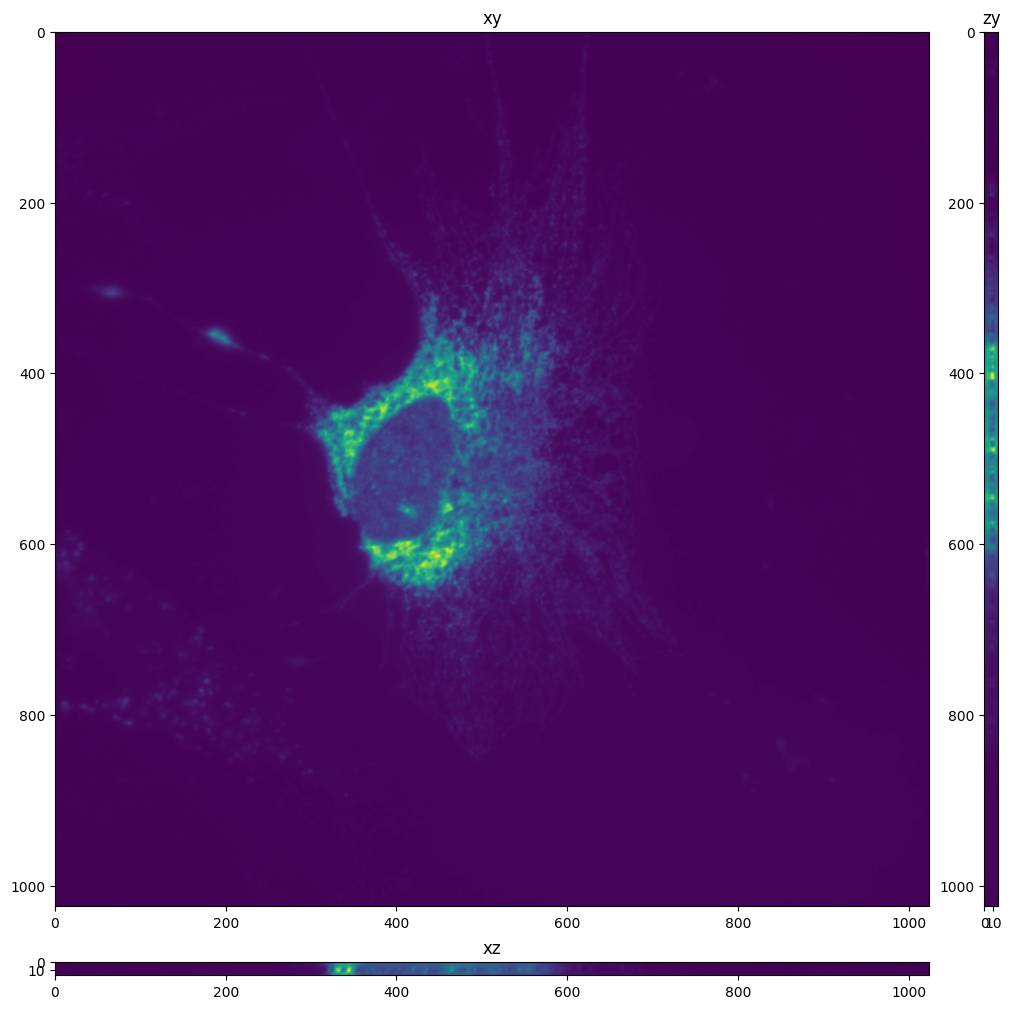

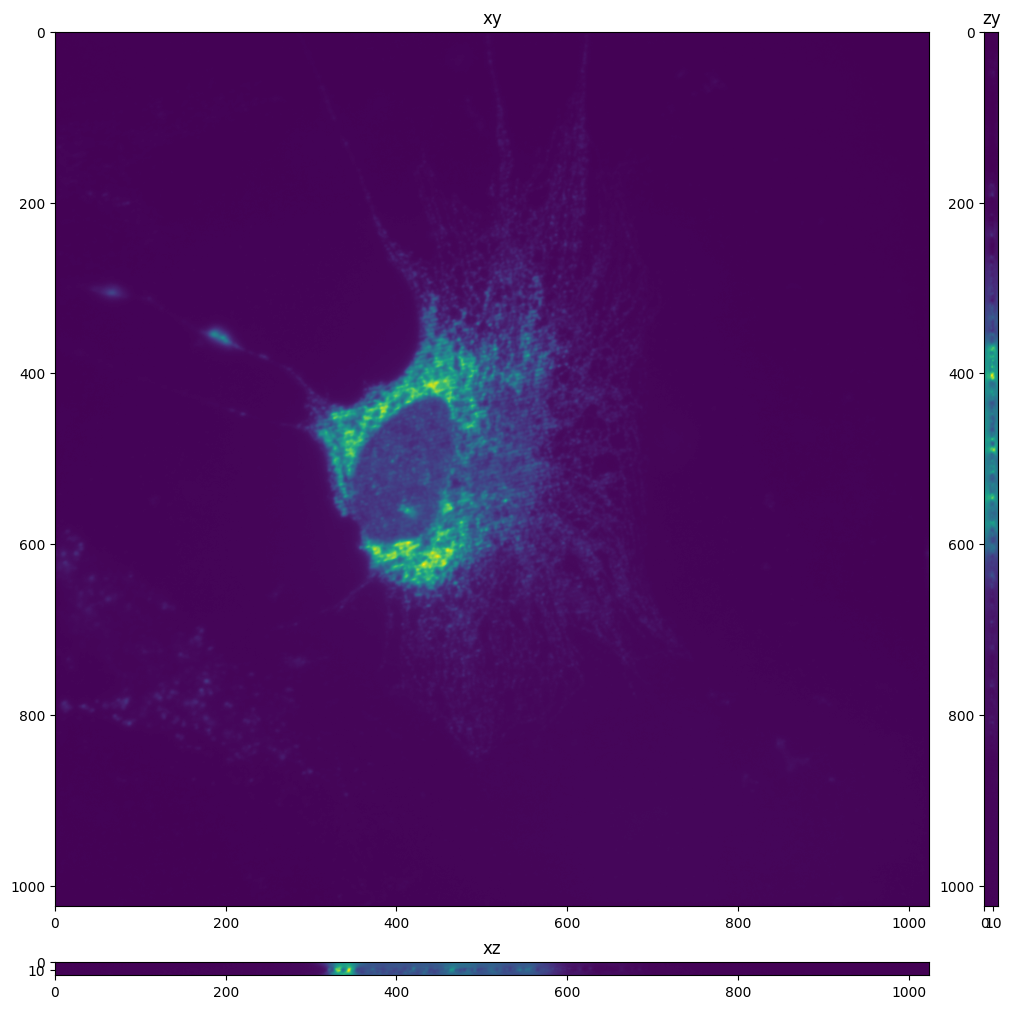

In [17]:
separated_mean = np.mean(separated, axis=0)

fig = show_xyz_slice_center(separated[0,:,:,:])
fig = show_xyz_slice_center(separated_mean)

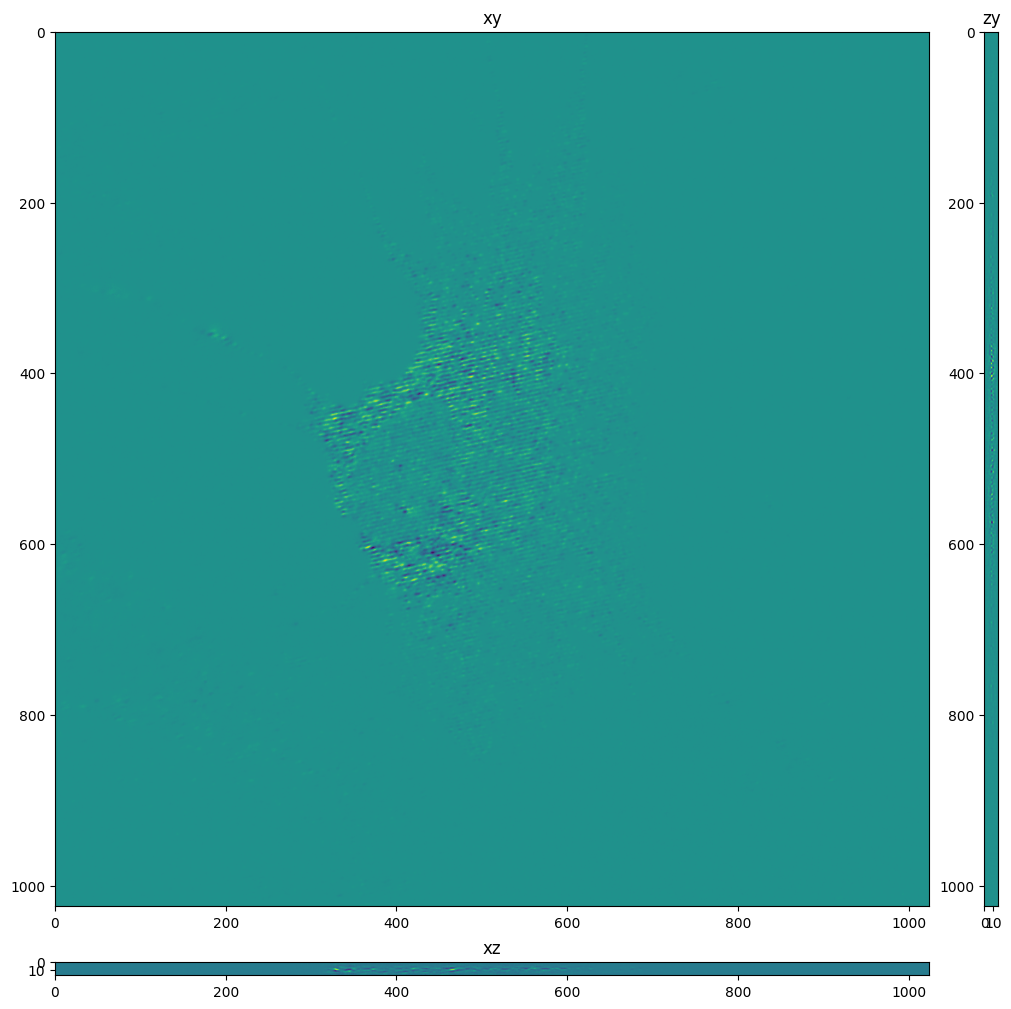

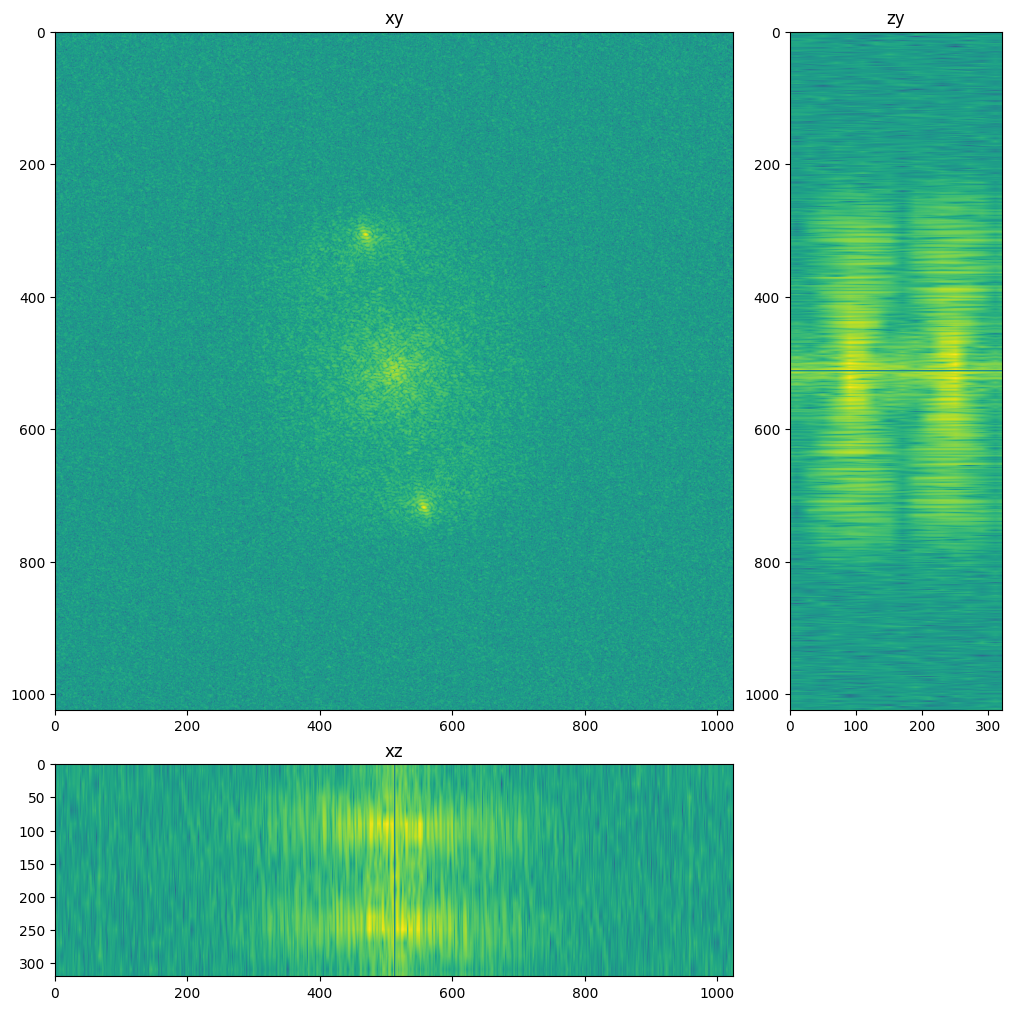

In [18]:
n=1
test = separated[n]

#test = data[0]+data[1]+data[2]+data[3]+data[4]

fig = show_xyz_slice_center(test)

fft = np.fft.fftn(test)
#print(band.shape)
fft = np.fft.fftshift(fft)
band = np.abs(fft)**2
band = np.log(band)

fig = show_xyz_slice_center(band, sxy=1, sz=20)


In [12]:
import napari
viewer = napari.Viewer()
viewer.add_image(test)

<Image layer 'test' at 0x238b74b2d30>

In [11]:
test.shape[1], test.shape[1]//2

(1024, 512)

In [97]:
freq_padded = np.pad(fft, ((0,0), (test.shape[1]//2,test.shape[1]//2), (test.shape[2]//2,test.shape[2]//2)), 'constant', constant_values = 0)

TypeError: Image data of dtype complex128 cannot be converted to float

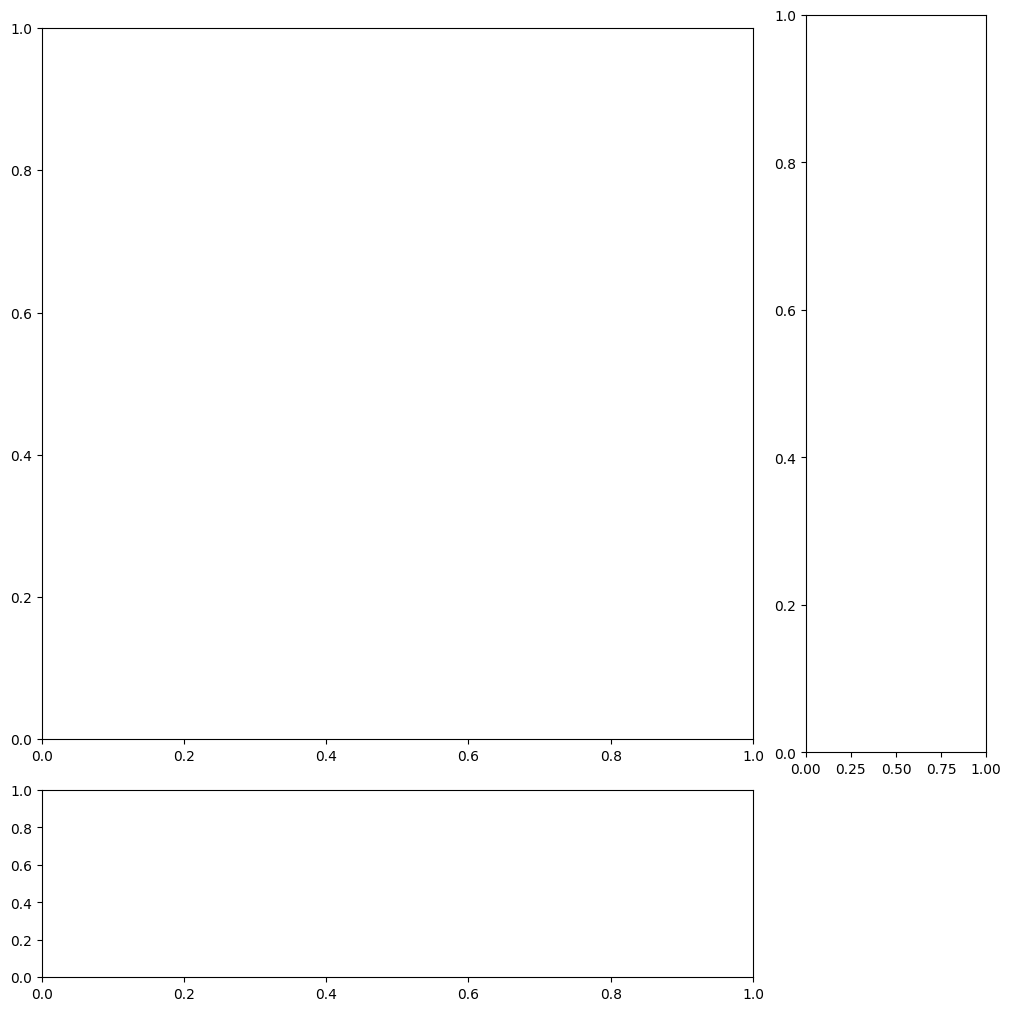

In [98]:
fig = show_xyz_slice_center(freq_padded)

(65, 256, 256)


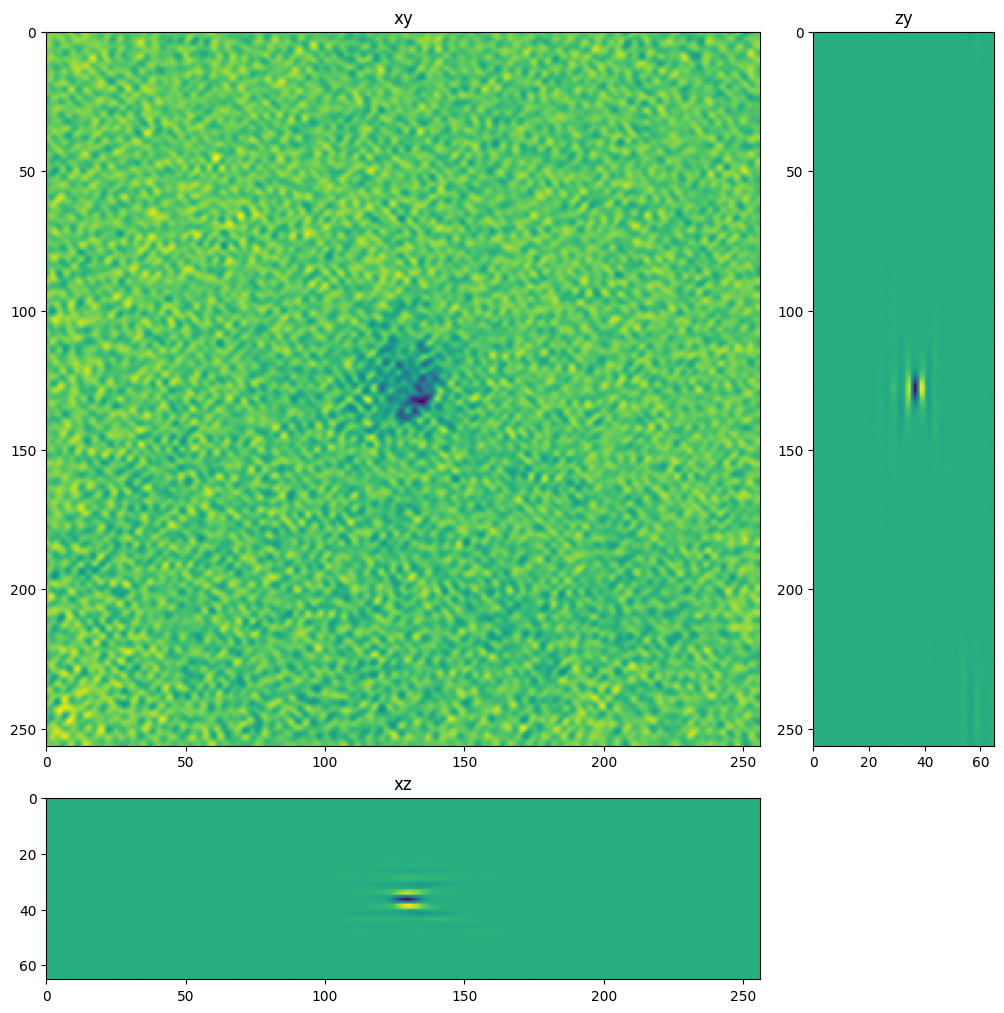

In [ ]:

fft = np.fft.fftn(test)
fft = np.fft.fftshift(fft)
freq_padded = np.pad(fft, ((0,0), (fft.shape[1]//2,fft.shape[1]//2), (fft.shape[2]//2,fft.shape[2]//2)), 'constant', constant_values = 0)
freq_padded_shift = np.fft.ifftshift(freq_padded)
#fig = show_xyz_slice_center(freq_padded_shift)
inverse = np.fft.ifftn(freq_padded_shift)
#inverse = np.fft.ifftshift(inverse)
print(inverse.shape)
fig = show_xyz_slice_center(inverse.real)

In [ ]:
from clij2fft.richardson_lucy import richardson_lucy_nc

In [85]:

from skimage.restoration import wiener
separated[1].shape, psfs[1].shape
separated[1].dtype, psfs[1].dtype

(dtype('float64'), dtype('float32'))

In [99]:
separated[3]=separated[3]-separated[3].min()+0.00001
separated[4]=separated[4]-separated[4].min()+0.00001

In [122]:
import napari

viewer = napari.Viewer()
viewer.add_image(psfs[0])
viewer.add_image(psfs[1])
viewer.add_image(psfs[2])

<Image layer 'Image [2]' at 0x1e9251c1250>

In [123]:
psfs=[]
for i in range(3):
    temp=imread(r'D:\Janelia\Data 2024-06-12\561nm OTF used\psf_3d_'+str(i)+'.tif')
    psfs.append(temp)

psfs[0][psfs[0]<0.00001]=0
psfs[2][psfs[2]<0.00001]=0

psfs[0]=psfs[0]/psfs[0].sum()
psfs[1]=psfs[1]/psfs[1].sum()
psfs[2]=psfs[2]/psfs[2].sum()


In [124]:
from skimage.io import imread
from skimage.restoration import wiener



decon1 = richardson_lucy_nc(separated[0], psfs[0], 100)
decon2 = wiener(separated[1], psfs[1], 0.01, clip=False)
decon3 = wiener(separated[2], psfs[1], 0.000001, clip=False)
decon4 = richardson_lucy_nc(separated[3], psfs[2], 100)
decon5 = richardson_lucy_nc(separated[4], psfs[2], 100)
total = decon1+decon2+decon3+decon4+decon5

get lib
calling convcorr 0 0
get lib
calling convcorr 0 0
get lib
calling convcorr 0 0


In [125]:
print(separated[3].min(), separated[3].max())
decon4.min(), decon4.max()

1e-05 5379.099112231819


(236.14926, 77326.78)

(1e-05, 1085148062.5276356, 1e-06, 2.0649598)

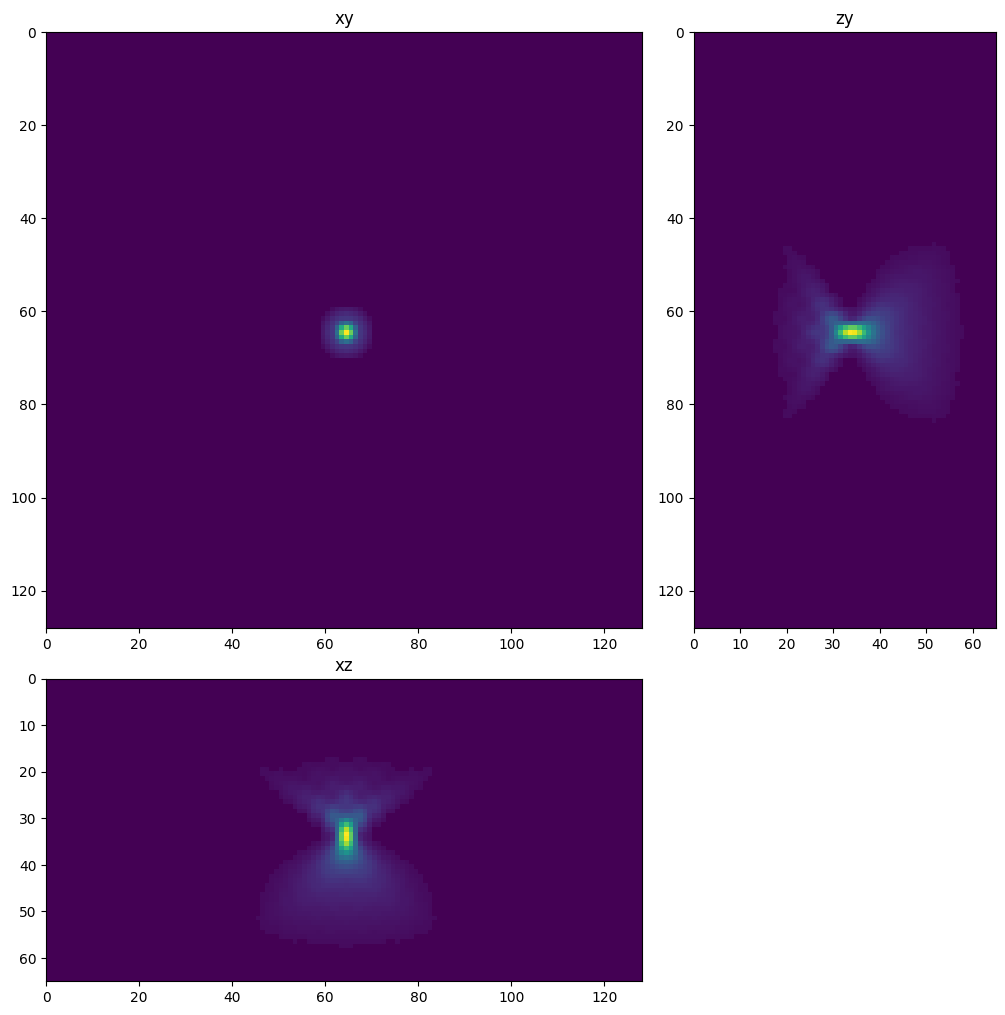

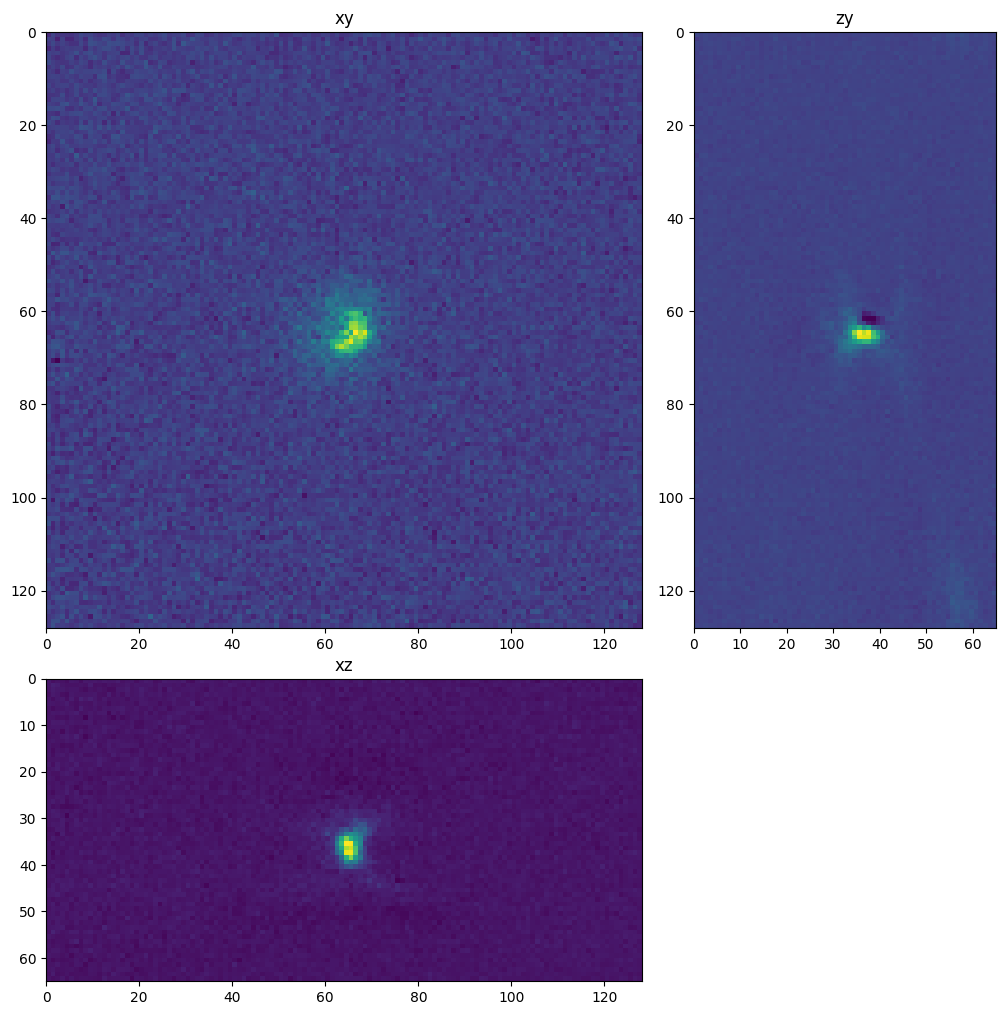

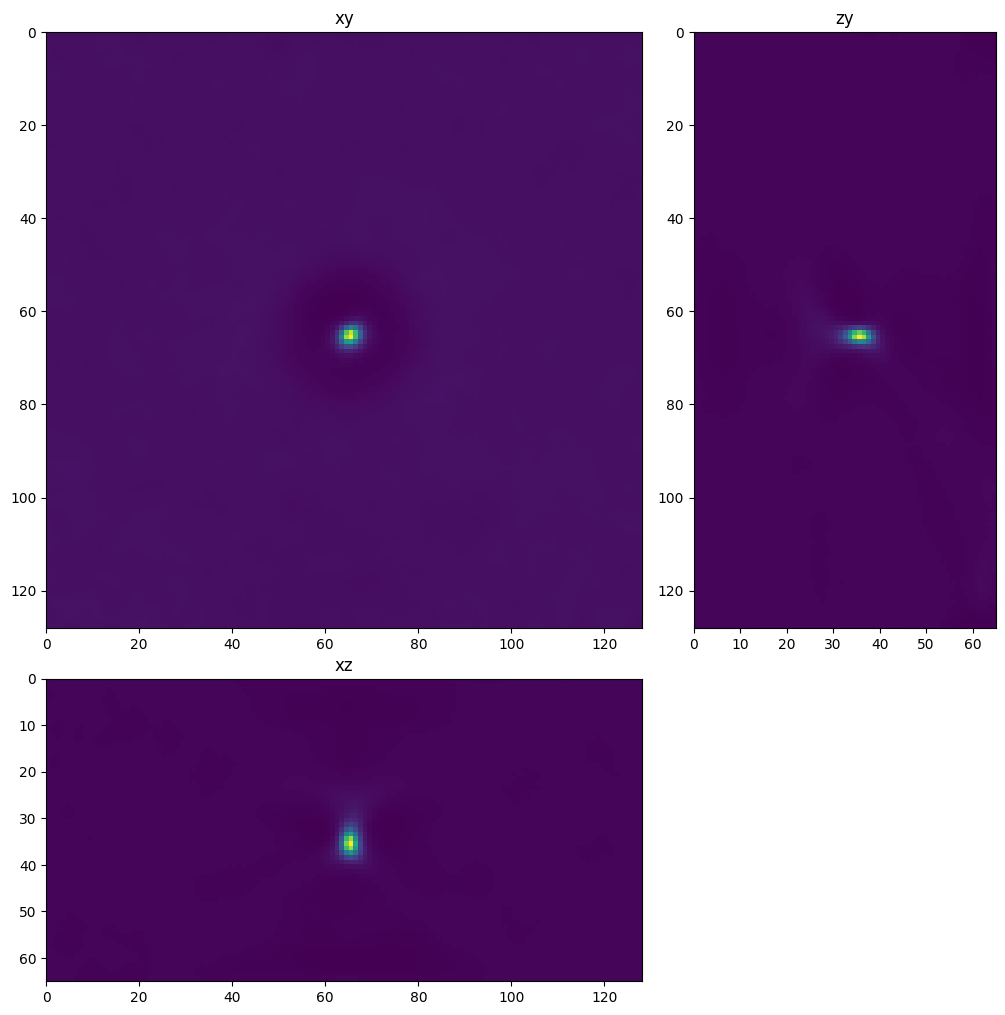

In [126]:
psfs[2] = psfs[2]+psfs[2].min()+0.000001
fig = show_xyz_slice_center(psfs[2])
fig = show_xyz_slice_center(separated[3])
fig = show_xyz_slice_center(decon4)
separated[3].min(), separated[3].sum(), psfs[2].min(), psfs[2].sum()

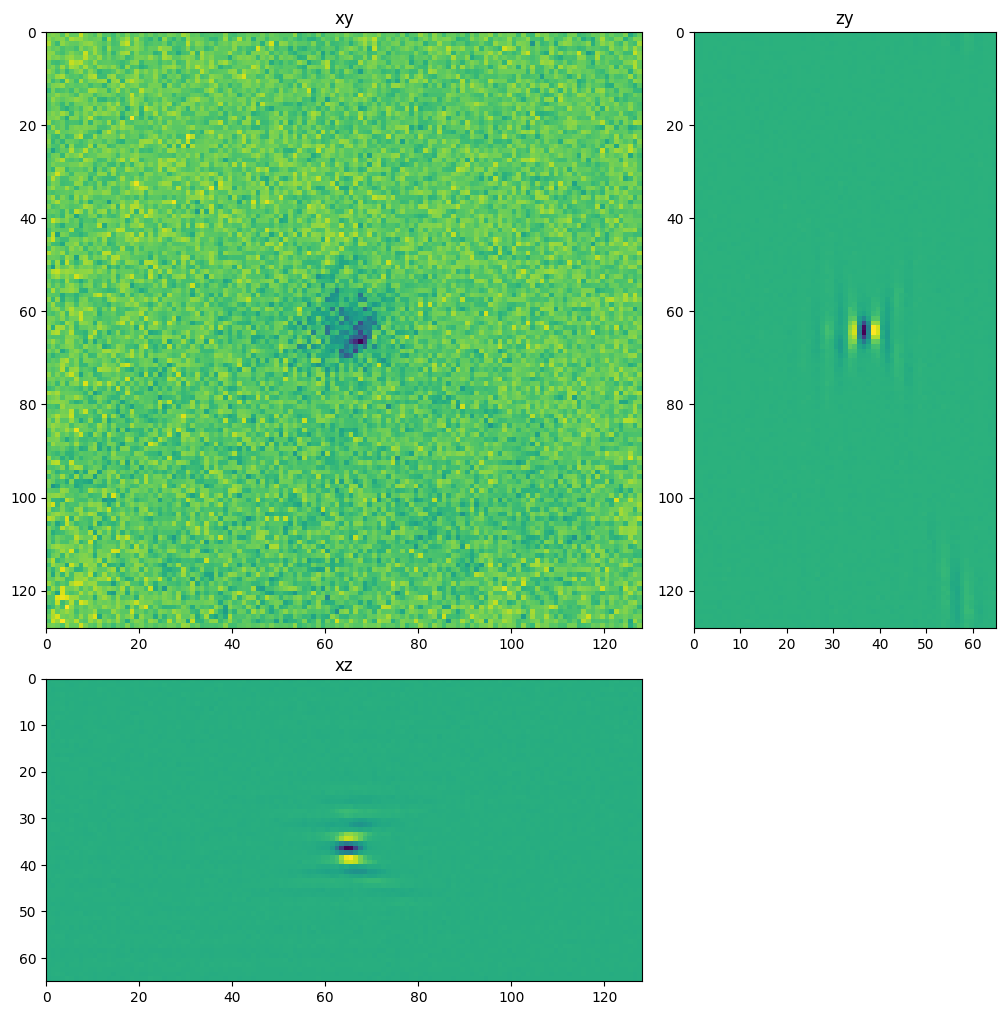

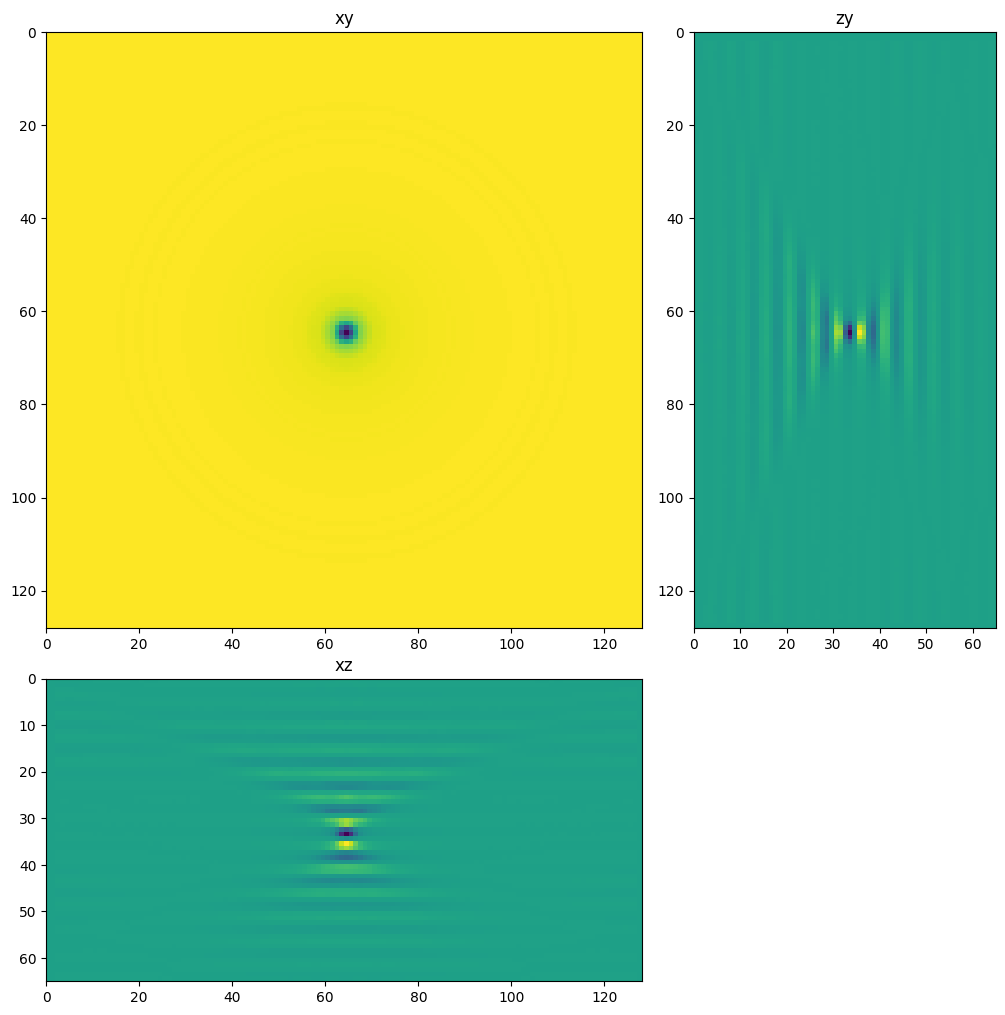

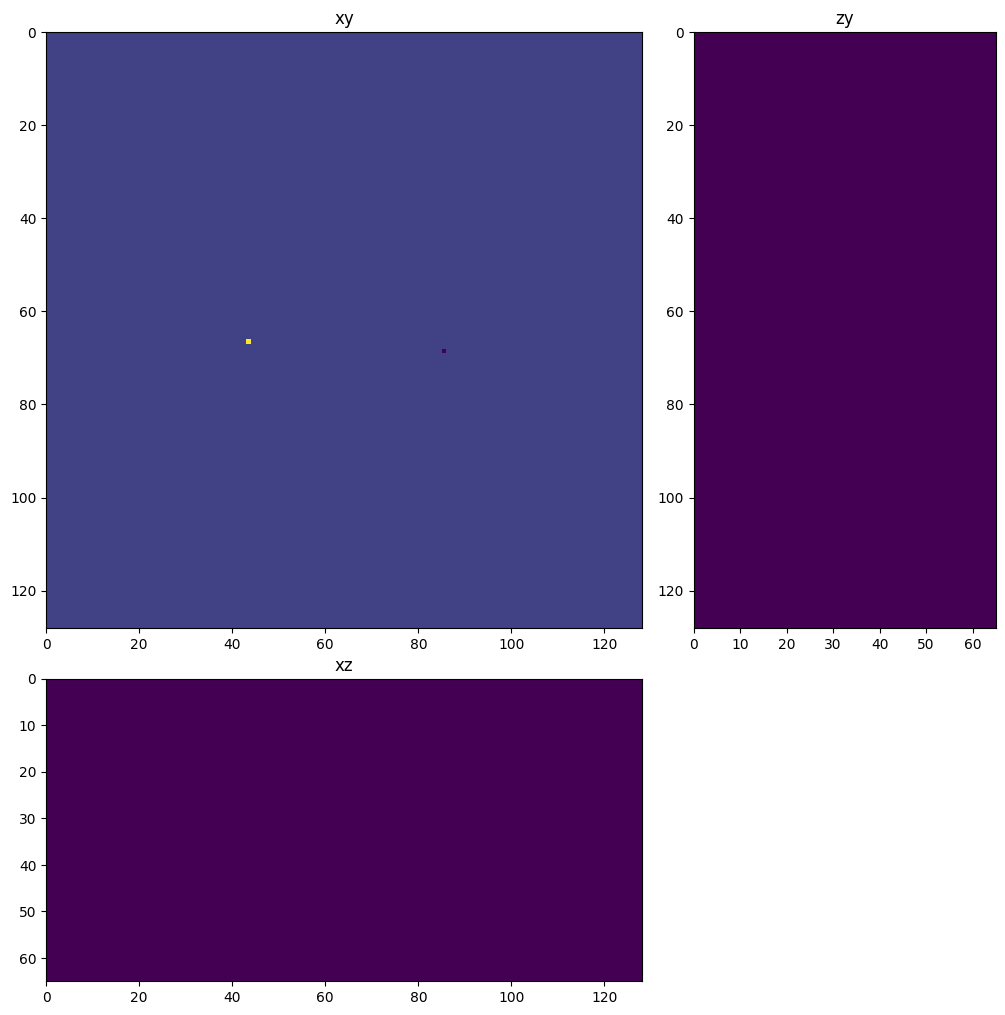

In [17]:
fig = show_xyz_slice_center(separated[1])
fig = show_xyz_slice_center(psf)
fig = show_xyz_slice_center(decon)

float32 float32 12249.450739793818


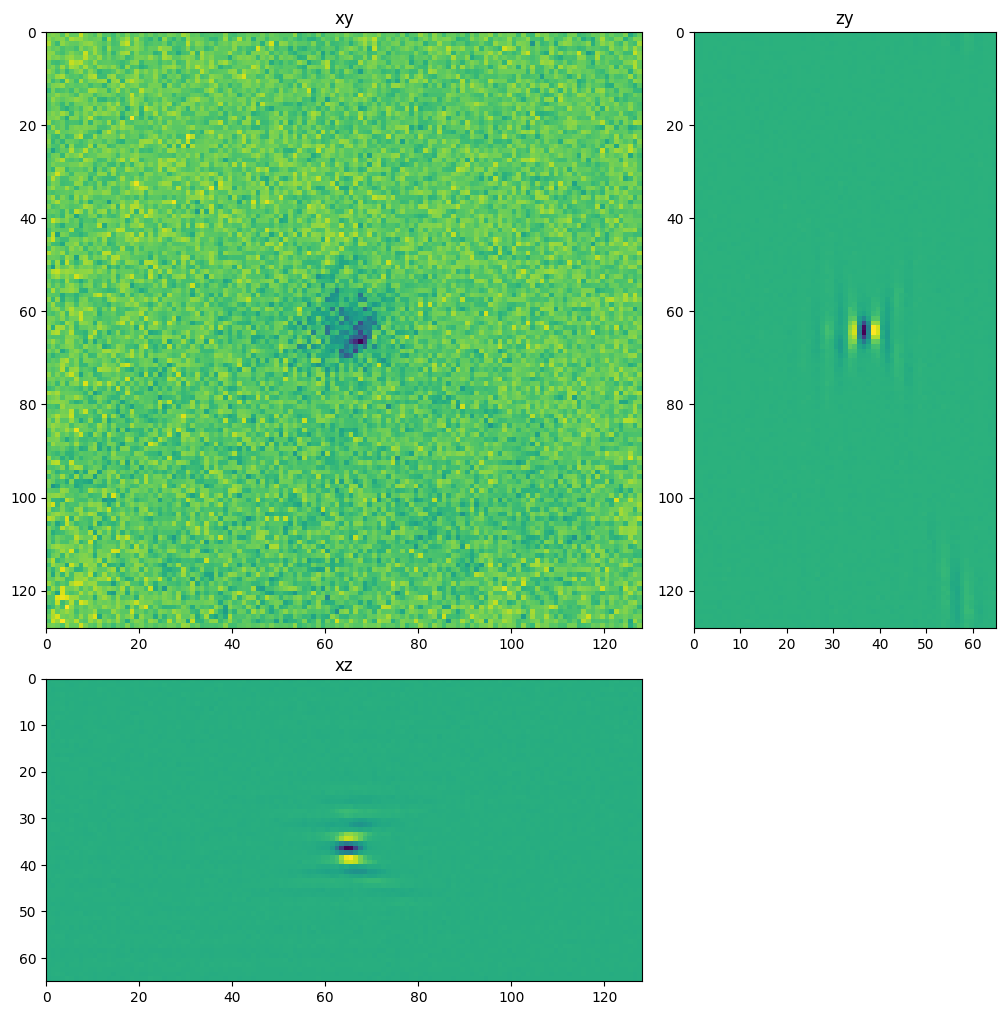

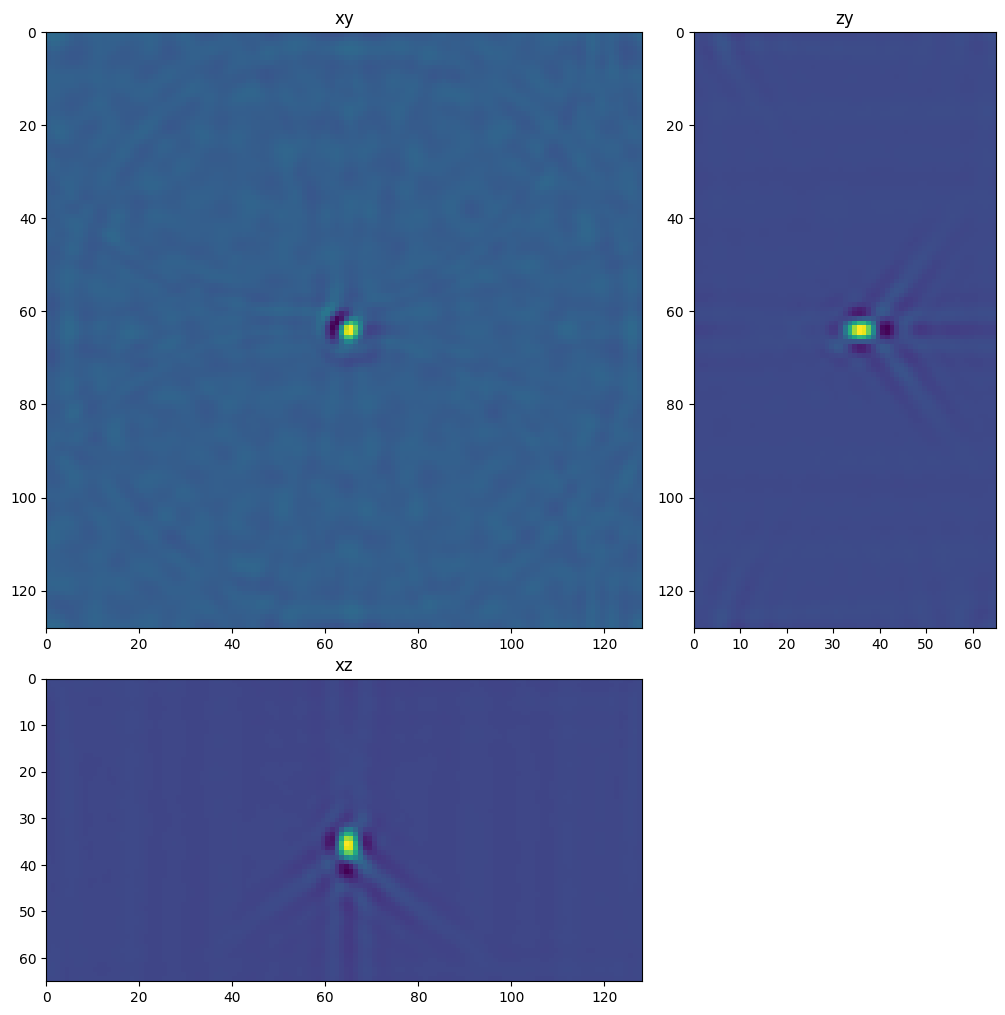

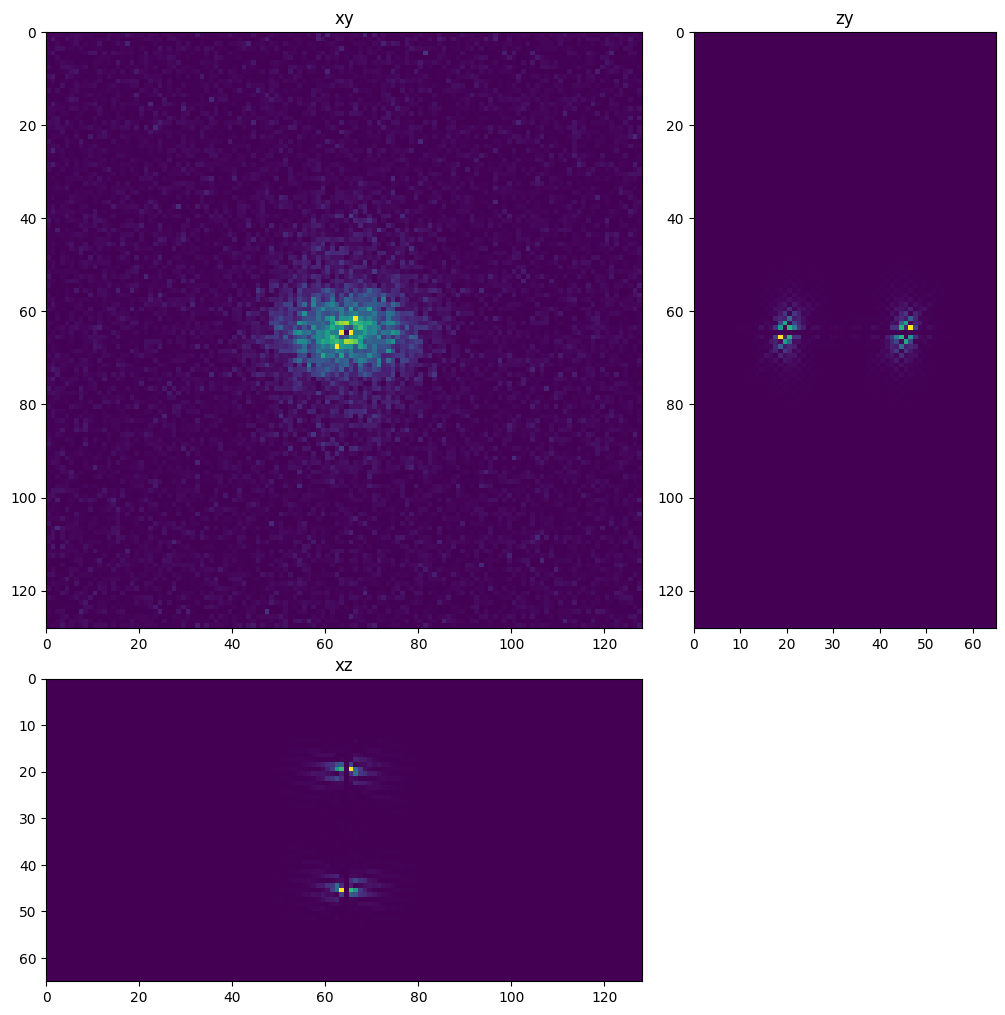

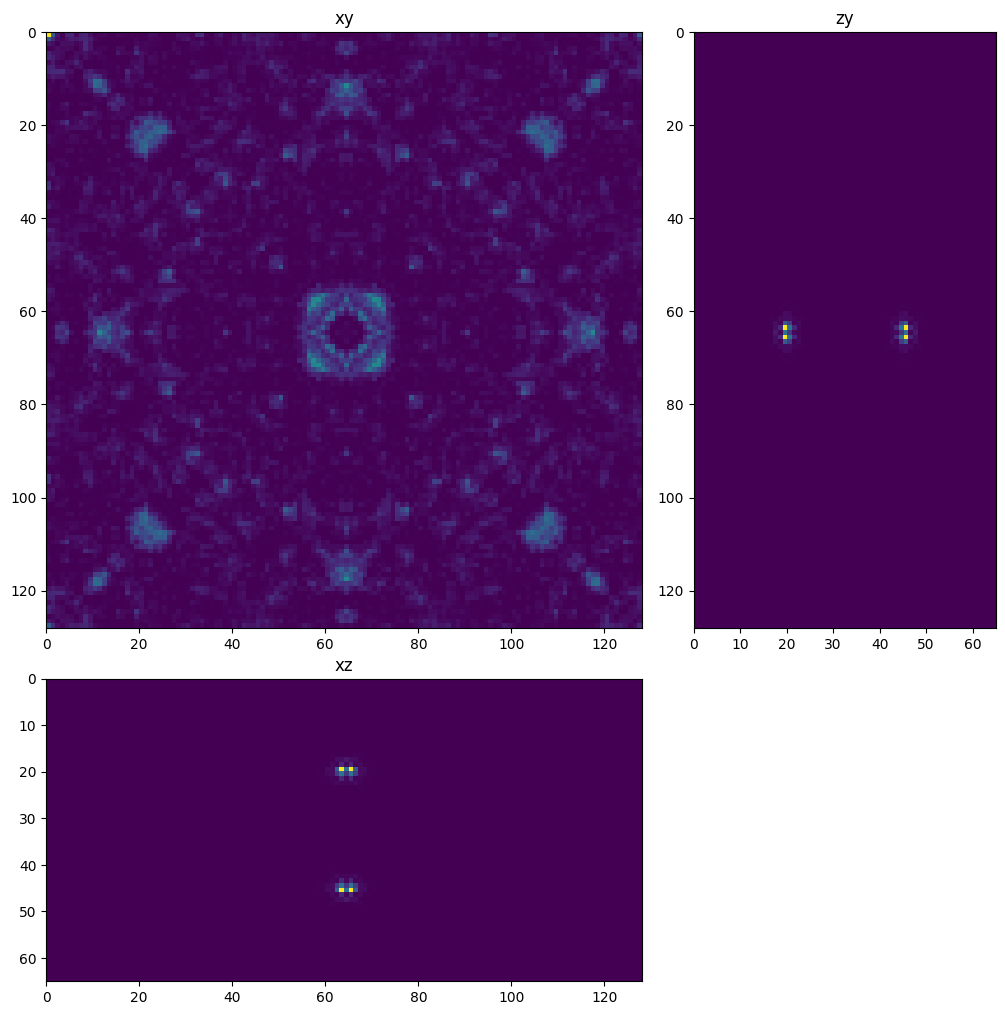

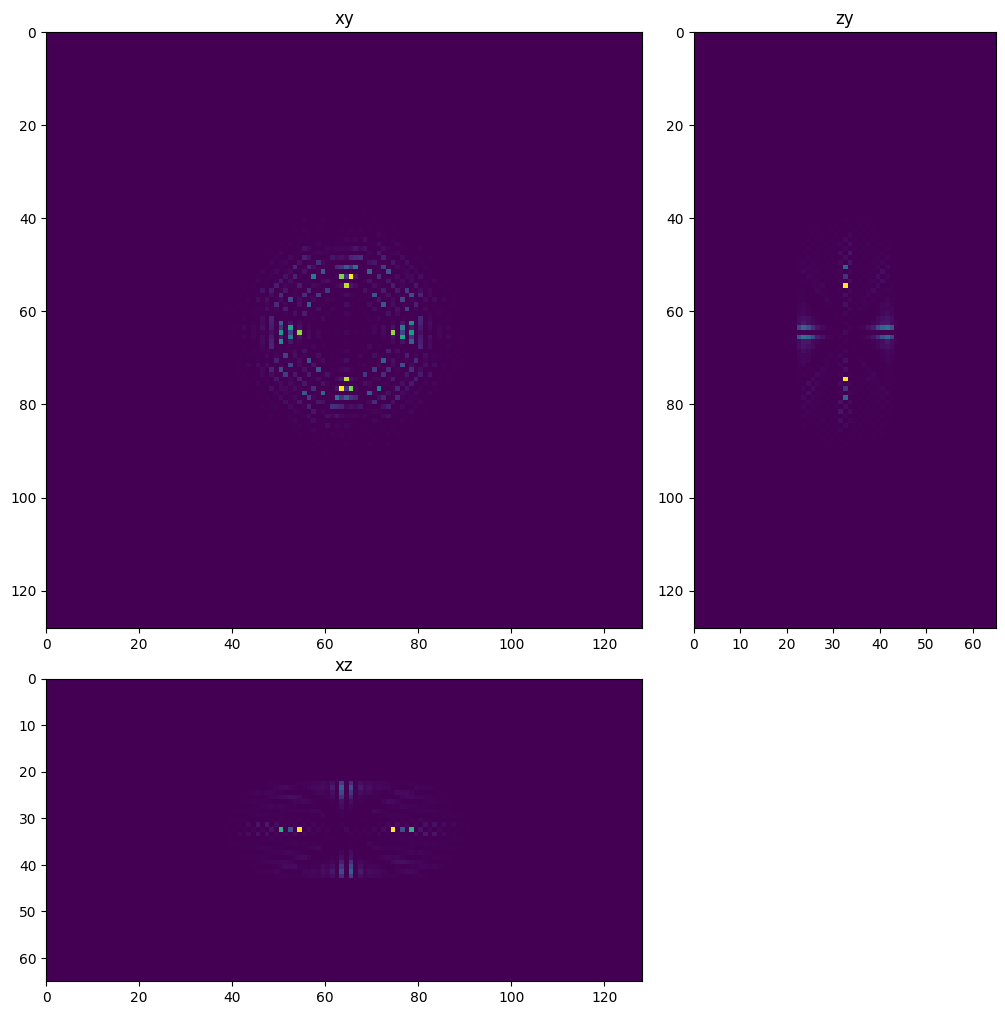

In [52]:

fig = show_xyz_slice_center(separated[1])

input = separated[1].astype('float32')

decon = wiener(separated[0], psfs[0], 0.0000001,clip=False)
fig = show_xyz_slice_center(decon)
print(input.dtype, psfs[1].dtype, separated[1].max())

input_fft = np.fft.fftn(input)
input_fft = np.fft.fftshift(input_fft)
band = np.abs(input_fft)**2
fig = show_xyz_slice_center(band)

psf_fft = np.fft.fftn(psfs[1])
psf_fft = np.fft.fftshift(psf_fft)
band_psf = np.abs(psf_fft)**2
fig = show_xyz_slice_center(band_psf)

decon_fft = np.fft.fftn(decon)
decon_fft = np.fft.fftshift(decon_fft)
band_decon = np.abs(decon_fft)**2
fig = show_xyz_slice_center(band_decon)

float32


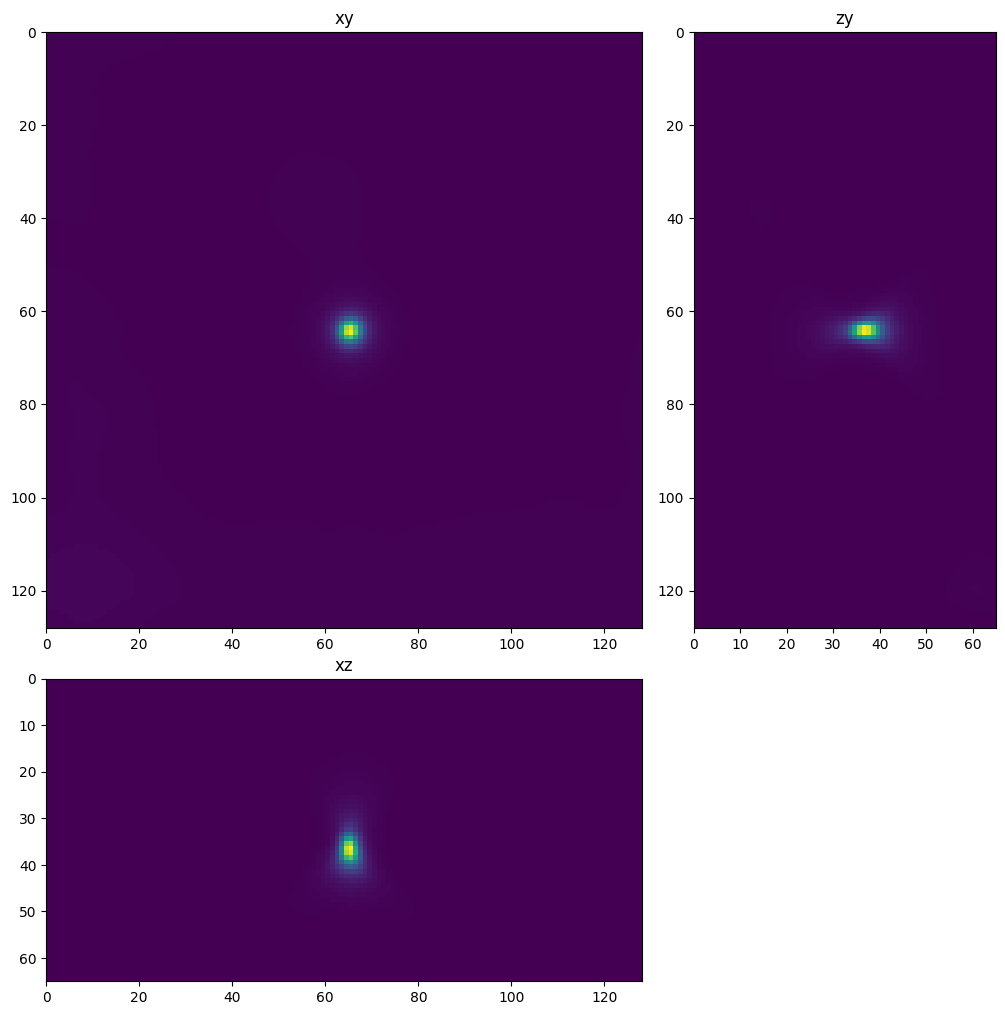

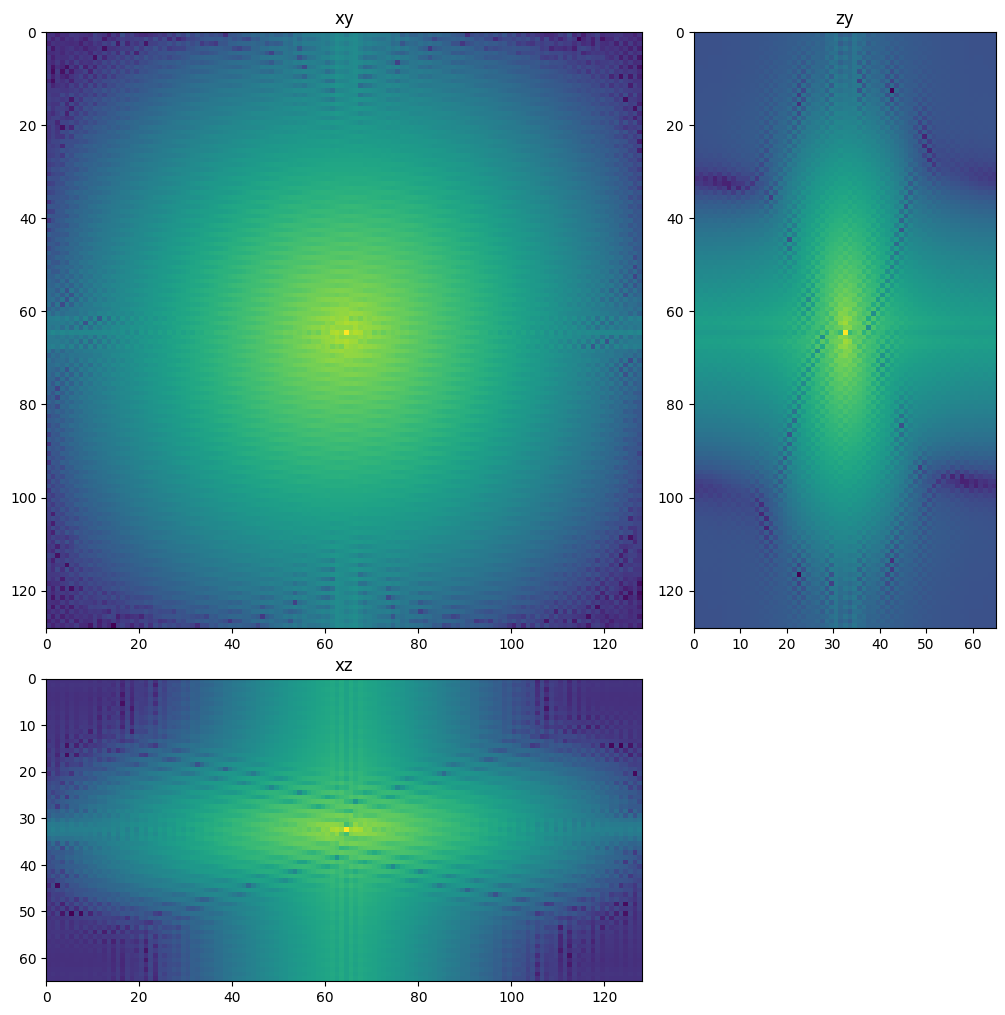

In [46]:
signal = decon1#separated[1]

fig = show_xyz_slice_center(signal)

print(signal.dtype)

psf_fft = np.fft.fftn(signal)
psf_fft = np.fft.fftshift(psf_fft)
band_psf = np.abs(psf_fft)**2
band_psf = np.log(band_psf)
fig = show_xyz_slice_center(band_psf)